<h1 style="text-align: center;"><a title="Data Science-AIMS-Cmr-2021-22">Convolutional Neural Networks for Image classification </h1>



***NOTE***

<font color="red">**Be sure to use hardware acceleration to use the GPU. Click on `Runtime`, change `runtime type`, and select `GPU` for the *hardware accelerator* option. Try to limit your time with the GPU. Terminate the session when possible due to limitations.**

## <font color="green"> Learning outcomes:

* learn how implement CNNs

* learn about ```Conv2D, MaxPool2D, Flatten, Dropout```

* learn how to implement ```ModelCheckpoint``` and view them in the file system

* learn how to convert softmax output into class predictions

## <font color="green">Data information:

* Features: (28x28) images

* Output: 10 classes represented by integers

## <font color="green">Tasks for participants (boolean)?

* Yes, at the end (try avoid copy/pasting code, rather write it out)


## Imports first

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import pandas as pd
%matplotlib inline

## Load the dataset

We will use the FashionMNIST dataset. Documentation https://www.tensorflow.org/datasets/catalog/fashion_mnist

By the way, there are a ton of datasets already available to you from Tensorflow, check them out here: https://www.tensorflow.org/datasets/catalog/overview

Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

Note that the data has already been split into training and testing for us, phew! What's next though?

In [2]:
# load data
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


## View the shape

In [3]:
print('Training data shape : ', X_train.shape, Y_train.shape)

Training data shape :  (60000, 28, 28) (60000,)


In [4]:
print('Testing data shape : ', X_test.shape, Y_test.shape)

Testing data shape :  (10000, 28, 28) (10000,)


## Find the unique numbers from the train labels

From what we see below, we don't need to worry about label encoding as all the classes are integer values from 0 to 9 with no gaps between the values. Given that we have 10 classes, what does this tell us about the last layer in our network?

In [5]:
classes = np.unique(Y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


## Plot some of the data

You can change the value of ```data_point``` to explore different images

Text(0.5, 1.0, 'Ground Truth : 6')

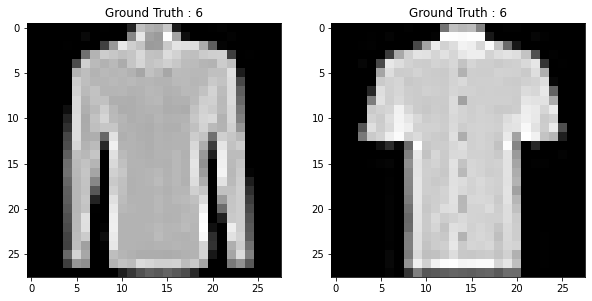

In [7]:
data_point = 40

plt.figure(figsize=[10,5])
 
# Display the first image in training data
plt.subplot(121)
plt.imshow(X_train[data_point,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(Y_train[data_point]))
 
# Display the first image in testing data
plt.subplot(122)
plt.imshow(X_test[data_point,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(Y_test[data_point]))

## Reshape needed

Tensorflow wants to know the depth of an image. API https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

For CNNS, Tensorflow wants the format of the data as follows: [batches, rows, columns, depth]. 

In this case the colour channel/depth of the images is 1. Currently the shape is:

In [8]:
X_train.shape

(60000, 28, 28)

We have a width of 28 and a height of 28 but no depth. So we can reshape it to include a value of one using the Numpy reshape function. Documentation https://numpy.org/doc/stable/reference/generated/numpy.reshape.html

In [9]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

## View the shape

In [10]:
print('Training data shape : ', X_train.shape, Y_train.shape)

Training data shape :  (60000, 28, 28, 1) (60000,)


In [11]:
print('Testing data shape : ', X_test.shape, Y_test.shape)

Testing data shape :  (10000, 28, 28, 1) (10000,)


## Take a look at a single image

In [12]:
X_train[0]

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
      

## What is the min/max for this image?

In [13]:
np.max(X_train[0])

255

In [14]:
np.min(X_train[0])

0

## Normalise

We need to normalise the data since the values range from 0 to 255. Training NNs on data ranging between [0,1] is recommended.

Need to normalise all features, including training, validation and testing. We also need to apply the same normalisation to any new data (obtained in the future).

In [15]:
X_train = X_train / 255
X_test = X_test / 255

## Take a look at a single image (after normalisation)

In [16]:
X_train[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

## What is the min/max for this image after normalisation?

In [17]:
np.max(X_train[0])

1.0

In [18]:
np.min(X_train[0])

0.0

## One hot encoding

## Before

In [19]:
Y_test[0]

9

## Convert from categorical labels to one-hot encoded vectors

In this case there are 10 classes so we can tell the function to convert into a vector of length 10

In [20]:
Y_train = np_utils.to_categorical(Y_train, 10)
Y_test = np_utils.to_categorical(Y_test, 10)
num_classes = 10

## After

In [21]:
Y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

## Create a CNN model

A lot of things here are not new. 

Creating a sequential model is not new.

Dropout is not new

Creating a fully connected layer is not new.

Creating a softmax output is not new.

What's new is: Conv2D, MaxPooling2D and Flatten

Documentation:

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten

## Building the CNN Architecture

* On the first layer, we need to specify the `input shape`. Only here, only once. There below, we are creating 64 filters each of size 2x2. What will be the depth of each of those 64 filters? What will be the resulting depth of the feature map after applying these filters?


*  	one of "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input. When padding="same" and strides=1, the output has the same size as the input.


* Here we create a 2x2 max pooling layer


* In order to pass output from the convolutional block to the dense block, we must flatten each example  in the minibatch. In other words, we take this four-dimensional input [batch, width, height, depth] and transform it  into the two-dimensional input [batch, units/input dimensions] expected by fully-connected layers

In [22]:
Conv2D?

In [23]:
def baseline_model():

    model = Sequential()


   
    model.add(Conv2D(filters=64, kernel_size=2,  padding='same', activation='relu', input_shape=(28,28,1))) 
    
    
    model.add(MaxPool2D(pool_size=2))

    
    model.add(Flatten())
    
    model.add(Dense(64, activation='relu'))
    
    model.add(Dropout(0.5))

    model.add(Dense(32, activation='relu'))

    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='softmax'))

    optimizer = SGD(learning_rate=0.9)
    loss = CategoricalCrossentropy()
    
    # Compile the model
    model.compile(loss=loss,
             optimizer=optimizer,
             metrics=['accuracy'])
    return model

In [24]:
model = baseline_model()

## Determine the number of trainable parameters

Look at how many parameters we get from the last layer in the feature extractor to the first fully connected layer in the classifier!

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 64)                802880    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                        

Now let's do something new. Let's save the model weights while training and keep track of the best model on the validation accuracy.

API for saving checkpoints https://www.tensorflow.org/tutorials/keras/save_and_load and https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

Additional things like the ability to determine the latest checkpoint exists: `tf.train.latest_checkpoint`. Take a look at the documentation for more interesting things.

In [26]:
checkpoint_path = "training/cp-{epoch:04d}.ckpt"

cp_callback = ModelCheckpoint(filepath=checkpoint_path, 
                              save_best_only=True, 
                              save_weights_only=True, 
                              verbose=1)

## Begin training

In [27]:
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=256, verbose=1, callbacks=[cp_callback])

Epoch 1/10
234/235 [============================>.] - ETA: 0s - loss: 1.4627 - accuracy: 0.4287
Epoch 1: val_loss improved from inf to 0.67374, saving model to training/cp-0001.ckpt
235/235 [==============================] - 10s 9ms/step - loss: 1.4617 - accuracy: 0.4291 - val_loss: 0.6737 - val_accuracy: 0.7546
Epoch 2/10
231/235 [============================>.] - ETA: 0s - loss: 0.7568 - accuracy: 0.7230
Epoch 2: val_loss improved from 0.67374 to 0.50093, saving model to training/cp-0002.ckpt
235/235 [==============================] - 2s 8ms/step - loss: 0.7557 - accuracy: 0.7233 - val_loss: 0.5009 - val_accuracy: 0.8333
Epoch 3/10
233/235 [============================>.] - ETA: 0s - loss: 0.6610 - accuracy: 0.7655
Epoch 3: val_loss improved from 0.50093 to 0.47801, saving model to training/cp-0003.ckpt
235/235 [==============================] - 2s 8ms/step - loss: 0.6605 - accuracy: 0.7656 - val_loss: 0.4780 - val_accuracy: 0.8259
Epoch 4/10
228/235 [============================>.] 

Check on the left using the `file` option. You'll see a new folder and the checkpoints saved. Next let's get the correct testing values and then compare the predictions on the test data when initialising the model as opposed to loading the best weights from training and predicting again on the test data.

In [ ]:
correct_values = np.argmax(Y_test,axis=1)

In [ ]:
model = baseline_model()
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=-1)

accuracy_score(predictions,correct_values)*100

In [ ]:
model = baseline_model()
model.load_weights("training/cp-0010.ckpt")

predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=-1)

accuracy_score(predictions,correct_values)*100

## Predict on one example

In [ ]:
model.predict(np.expand_dims(X_test[0], axis=0))

## Predicting, but obtaining the probabilities

In [ ]:
prediction = model.predict(np.expand_dims(X_test[0], axis=0))
np.argmax(prediction, axis=-1)

## Predict on all the test data

In [ ]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=-1)

In [ ]:
predictions[0:10]

Before applying the `accuracy_score` function we need to conver the data into single class integers. In it's current form, the Y_test values aren't suitable. To address this, we can use the `np.argmax` function.

In [ ]:
confusion_matrix(predictions,correct_values)

# Task:

1) Add another convolutional layer to the current model.

2) Add another max pooling layer to the current model.

3) Modify the network and try improve your performance by using different architectures and hyper-parameters.

4) Replace the max pooling with average pooling

5) Add a stride of 2 to your average pooling layer



# References:

* This notebook was adpated from Dr. Emmanuel Dufourq,  2021 Gene Golub SIAM Summer School 